In [ ]:
!pip install pafy
!pip install youtube-dl
#!pip uninstall -y opencv-python opencv-contrib-python
#!apt install python3-opencv

# Classes

In [28]:
import cv2
import numpy as np
from PIL import Image
import io

class ImageWidget(object):
    def __init__(self, image=None):
        self.image_w = widgets.Image(format='PNG')
        self.setImage(image)
        #display(self.image_w)    
    
    def display(self):
        display(self.image_w)  
    
    def getByteArray(self,image):    
        #return None
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr
    
    def setImage(self,image):
        if image != None:
            #print('set image', type(image))
            self.image_w.value = self.getByteArray(image)    
            
    def getImage(self):
        return Image.open(io.BytesIO(self.image_w.value))

In [179]:
class BaseAction(object):
    
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : self.__dict__}

In [180]:
# input: image, output cropped image
class CropAction(BaseAction):
    WORLD = 0
    NORMALIZED = 1
    # __init__ is a special method called whenever you try to make
    # an instance of a class. As you heard, it initializes the object.
    # Here, we'll initialize some of the data.
    #def __init__(self, image=None, size=None, min=[0.0,0.0], max=[1.0,1.0]):
    def __init__(self,size=None, min=None, max=None,mode=WORLD):
        self.min  = min
        self.max  = max
        self.size = size
        self.mode = mode
        
    def evaluate(self, image=None):
        if self.mode == self.WORLD:
            return image.crop(self.flat())
        return image.crop(self.fromNormalized(self.flat(), size=image.size))      
        
    def flat(self):
        return (self.min[0],self.min[1],self.max[0],self.max[1])
    
    def normalizeValue(self, value, size):
        return float (value) / size

    def fromNormalizedValue(self, value,size):
        return int(value * size)

    def normalized(self):    
        #print(self.min, self.max, self.size)
        xmin = self.normalizeValue(self.min[0],self.size[0])
        ymin = self.normalizeValue(self.min[1],self.size[1])
        xmax = self.normalizeValue(self.max[0],self.size[0])
        ymax = self.normalizeValue(self.max[1],self.size[1])
        return (xmin,ymin,xmax,ymax)    

    def toNormalized(self):
        if self.mode == self.NORMALIZED:
            return self
        _norm = self.normalized()
        return CropAction(min=[_norm[0],_norm[1]], max=[_norm[2],_norm[3]], mode=self.NORMALIZED)
    
    def toWorld(self,size):
        if self.mode == self.WORLD:
            return self
        _world = self.fromNormalized(self.flat(),size=size)
        return CropAction(min=[_world[0],_world[1]], max=[_world[2],_world[3]], mode=self.WORLD)
    
    def fromNormalized(self, values, size=None):    
        if size == None:
            size = self.size
        xmin = self.fromNormalizedValue(values[0],size[0])
        ymin = self.fromNormalizedValue(values[1],size[1])
        xmax = self.fromNormalizedValue(values[2],size[0])
        ymax = self.fromNormalizedValue(values[3],size[1])
        return [xmin,ymin,xmax,ymax]
    
    def update(self, size=None):
        to = self.normalized()
        self.size = size
        self.min[0] = self.fromNormalizedValue(to[0],size[0])
        self.min[1] = self.fromNormalizedValue(to[1],size[1])
        self.max[0] = self.fromNormalizedValue(to[2],size[0]) - 1
        self.max[1] = self.fromNormalizedValue(to[3],size[1]) - 1

In [209]:
class CropWidget():
    def __init__(self, action=None, imageWidget=None, image=None, vstreams=None):
        self.image        = image
        self.action       = action
        self.imageWidget  = imageWidget
        self.vstreams     = vstreams
        self.index        = 0
        
        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        self.regions = dict()
        self.regions['reset'] = cropNormalizedArea
    
        if image != None:
            action.size = image.size
    
        self.reset_button = widgets.Button(description='Reset', disabled=False, tooltip='reset all values',style=style)
        self.reset_button.on_click(self.on_reset_button_clicked)  

        self.crop_name = widgets.Text(description = 'name',value = '', style=style, layout=layout,disabled=False)
        self.crop_name.on_submit(self.on_value_submit_crop_name)
        self.crop_list = widgets.Dropdown(description='region',options=self.regions.keys())
        self.crop_list.observe(self.crop_list_on_change) 
        self.crop_bookmarks = widgets.HBox([self.crop_list, self.crop_name, self.reset_button])

        self.imageselectw = widgets.IntSlider(value=0, min=0,max=len(vstreams)-1,step=1, description='image',layout=layout)
        self.imageselectw.observe(self.on_value_change_imageselectw, 'value')
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        image_select_hbox = widgets.HBox([self.imageselectw,self.next_image_button])
        
        self.cropx0 = widgets.IntSlider(value=0, min=0,step=1, description='x0',layout=layout)
        self.cropx1 = widgets.IntSlider(value=0, min=0,step=1, description='x1',layout=layout)
        self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        self.cropx1.observe(self.on_value_change_crop_xmax, 'value')

        self.cropy0 = widgets.IntSlider(value=0, min=0, step=1, description='y0',layout=layout)
        self.cropy1 = widgets.IntSlider(value=0, min=0, step=1, description='y1',layout=layout)
        self.cropy0.observe(self.on_value_change_crop_ymin, 'value')
        self.cropy1.observe(self.on_value_change_crop_ymax, 'value')
        
        crop_hbox_x = widgets.HBox([self.cropx0, self.cropx1])
        crop_hbox_y = widgets.HBox([self.cropy0, self.cropy1])
        crop_vbox   = widgets.VBox([image_select_hbox,self.crop_bookmarks,crop_hbox_x, crop_hbox_y])
        display(crop_vbox)
        self.imageWidget.display()
        self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))
        
    # RESULT 
    def crop_image(self):
        #return
        self.cropped_image = self.action.evaluate(image=self.image)
        #print(cropped_image.size)
        self.imageWidget.setImage(self.cropped_image)    
        
    def initMinMax(self,size,cropArea):
        self.cropx0.max = size[0]
        self.cropx1.max = size[0]
        self.cropy0.max = size[1] - 1
        self.cropy1.max = size[1] - 1

        self.cropx0.value = cropArea[0]
        self.cropy0.value = cropArea[1]
        self.cropx1.value = cropArea[2]
        self.cropy1.value = cropArea[3]    
        
    def on_value_change_crop_xmin(self,change):
        #print(type(change['new']))
        self.cropx1.min  = change['new']
        self.action.min[0] = change['new']
        self.crop_image()
            
    def on_value_change_crop_xmax(self,change):
        #print(change['new'],self.action.max)
        self.cropx0.max  = change['new']
        self.action.max[0] = change['new']
        self.crop_image()

    def on_value_change_crop_ymin(self,change):
        self.cropy1.min  = change['new']
        self.action.min[1] = change['new']
        self.crop_image()

    def on_value_change_crop_ymax(self,change):
        self.cropy0.max  = change['new']
        self.action.max[1] = change['new']
        self.crop_image()        
        
    # new bookmark event
    def on_value_submit_crop_name(self,change):
        #print(change)
        self.regions[change.value] = self.action.normalized()
        if change.value not in self.crop_list.options:
            self.crop_list.options = list(self.crop_list.options) + [change.value] 
        #(cropArea,image.size)
        #print(list(self.crop_list.options),self.crop_list.value, change.value)
        self.crop_list.value = change.value

    def crop_list_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            #print(self.regions[change['new']])
            #initMinMax(image.size,bookmark_dict[change['new']])
            #values = fromNormalizedMinMax(bookmark_dict[change['new']],image.size)
            #initMinMax(image.size,values)
            self.crop_name.value = change['new']
            #print('init',self.action.size,self.regions[change['new']])
            self.initMinMax(self.action.size,self.action.fromNormalized(self.regions[change['new']]))

    def on_reset_button_clicked(self,b):
        cropArea      = [0,0,image.size[0],image.size[1]]
        initMinMax(image.size,cropArea)
        crop_name.value = ''
        #crop_list.value = ''

    def updateImage(self,index):
        newimage = getVstream(vstreams=self.vstreams, index=index)   
        newsize = newimage.size
        self.action.update(newsize)
        self.image = newimage
        self.initMinMax(self.action.size,self.action.flat())
        #crop_image() 

    # select image slider
    def on_value_change_imageselectw(self,change):
        #imageselectw.disabled=True
        #global index
        self.index = change['new']
        self.updateImage(self.index)
        #imageselectw.disabled=False    

    def on_next_image_button_clicked(self,b):
        global vstreams
        self.vstreams = getVstreams(video=video, indexes=[self.index])
        self.updateImage(self.index)

cropWidget = CropWidget(action=CropAction(size=image.size, min=[0,0], max=list(image.size)),imageWidget=ImageWidget(), image=image, vstreams=vstreams)   

Image(value=b'', format='PNG')

In [223]:
#cropWidget.image = imgs[1]
#cropWidget.action.size = imgs[1].size
#imgs[1]


_action_dict = cropWidget.action.toNormalized().dict()


In [192]:
####################### scale
options={'NEAREST' : Image.NEAREST,'BOX' : Image.BOX,'BILINEAR' : Image.BILINEAR,'HAMMING' : Image.HAMMING,'BICUBIC' : Image.BICUBIC,'LANCZOS' : Image.LANCZOS}
#options={Image.NEAREST,Image.BOX,Image.BILINEAR,Image.HAMMING,Image.BICUBIC,Image.LANCZOS}
#size_options = {(128,128),(224,224),(240,240),(256,256),(299,299),(300,300),(320,320),(513,513)}
size_options = {'(128,128)' : (128,128), '(224,224)' : (224,224), '(240,240)' : (240,240), '(256,256)' : (256,256),
                '(299,299)' : (299,299),'(300,300)' : (300,300),'(320,320)' : (320,320),'(513,513)' : (513,513),
                '(640,480)' : (640,480)}


class ResizeAction(BaseAction):
    def __init__(self,size=None,use_w=False,use_h=False,algorithm=Image.NEAREST):
        self.size=size
        self.use_w=use_w
        self.use_h=use_h
        self.algorithm=algorithm
        
    def evaluate(self,image=None):
        w = self.size[0]
        h = self.size[1]
        #print(size,w,h)
        imagea = image

        ratio = h / imagea.size[1]
        newsize = (int(ratio * imagea.size[0]), int(ratio * imagea.size[1]) )

        ratio = w / imagea.size[0]
        h2 = int(ratio * imagea.size[1])
        w2 = int(ratio * imagea.size[0])
        if h2 > h:
            ratio = h / imagea.size[1]
            h2 = int(ratio * imagea.size[1])
            w2 = int(ratio * imagea.size[0])
        newsize = (w2, h2 )

        imageb = imagea.resize(newsize,self.algorithm)

        v = (int((self.size[0]-imageb.size[0])/2), int((self.size[1]-imageb.size[1])/2))
        new_im = Image.new("RGB", self.size) 
        new_im.paste(imageb, v)
        return new_im        

In [190]:

        
class ResizeWidget():
    def __init__(self, action=None, imageWidget=None, image=None):
        self.image        = image
        self.action       = action
        self.imageWidget  = imageWidget
                
        self.algorithmw = widgets.Dropdown(options=options,  description='algorithm', value = 0,style=style, layout=layout)
        #algorithmw.observe(self.algorithmw_on_change,'value') 
        self.sizew = widgets.Dropdown(options=size_options,  description='sizes', style=style, layout=layout)
        self.sizew.observe(self.sizew_on_change,'value') 

        self.widthw  = widgets.Text(description = 'width',value = '640', style=style, layout=layout,disabled=False)
        self.heightw = widgets.Text(description = 'height',value = '480', style=style, layout=layout,disabled=False)
        self.update_button = widgets.Button(description='Resize', disabled=False, tooltip='resize',style=style, layout=layout)
        self.update_button.on_click(self.on_update_button_clicked)  
        resize_vbox   = widgets.VBox([self.algorithmw,self.sizew,self.widthw,self.heightw,self.update_button])
        display(resize_vbox)    
        self.imageWidget.display()
        
    def algorithmw_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            print (change['new'])

    def sizew_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.widthw.value  =  str(change['new'][0])        
            self.heightw.value =  str(change['new'][1])  

    # the result: resized_image    
    def on_update_button_clicked(self,b):        
        new_size = (int(self.widthw.value),int(self.heightw.value))
        resized_image = self.action.evaluate(image=self.image,new_size=new_size,algorithm=self.algorithmw.value)
        self.imageWidget.setImage(resized_image)
        
resizeWidget = ResizeWidget(action=ResizeAction(),imageWidget=ImageWidget())         

Image(value=b'', format='PNG')

# Work

In [ ]:
# widgets Tool
 
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import Javascript, display
import uuid

style = {'description_width': '250px'}
layout = {'width': '500px'}
 
def addVisText(key='',value='',disabled=False, layout=layout):
    text = widgets.Text(description = key,value = value, style=style, layout=layout,disabled=disabled)
    display(text)  
    return text
    
def addVisCheckbox(key='',value=False,disabled=False):
    text = widgets.Checkbox(description = key,value = value,disabled=disabled, style=style, layout=layout)
    display(text)   
    return text

def addHeader(text='', bold=True):
    if bold == True:
        html = widgets.HTML(
        value="<b>" + text + "</b>",
        description=' ',
        style=style, layout=layout
        )
    else:
        html = widgets.HTML(
        value=text,
        description=' ',
        style=style, layout=layout
        )
    display(html)    

In [ ]:
#!pip install opencv-python
#!python -m pip install imutils
import cv2
import numpy as np
from PIL import Image

from IPython.display import display, clear_output
from PIL import ImageChops
import time

import numpy as np
from base.image_tool  import ImageTool


def getByteArray(image):    
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

In [ ]:
import pafy
import cv2
import time

# Shibuya Scramble Crossing Live Camera
url = "https://www.youtube.com/watch?v=lkIJYc4UH60"

#train
url = "https://www.youtube.com/watch?v=SRBLN7GEgY8"
   
# hongkong tram    
url = "https://www.youtube.com/watch?v=xlYniSPph4U"    
    
# london bus    
url = "https://www.youtube.com/watch?v=eNSxNEwjRd8"    
    
#EarthCam Live:  Times Square in 4K 2021-03-01 17:36
url = "https://youtu.be/eJ7ZkQ5TC08"

url = "https://youtu.be/XF4G5APigCc"
video = pafy.new(url)
print(video.title,video.streams)

In [ ]:
video.title.rsplit('2021')[0].rstrip()

# Videos create, init

In [ ]:
videos = dict()
#bookmark_dict['reset'] = cropNormalizedArea
#videos = []



In [ ]:
import pafy
import cv2
import time
import json

vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

def readImageOfStream(stream):
    capture = cv2.VideoCapture(stream.url)
    grabbed, frame = capture.read()
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return image

def getVstreams(video):
    vstreams=[]
    for stream in video.streams:
        image = readImageOfStream(stream)
        vstreams.append(image)
    return vstreams

def saveVideosFile(filename='videos.json'):
    with open('videos.json', 'w', encoding='utf-8') as f:
        json.dump(videos, f, ensure_ascii=False, indent=4)
        
def loadVideosFile(filename='videos.json'):
    with open('videos.json', 'r') as fp:
        videos = json.load(fp)  
        return videos

def videoContainerTo_Dict():
    container = dict()
    container['url'] = video_url.value
    #container['streams'] = video_streams.options
    container['title'] = video_title.value
    container['location'] = video_location.value
    container['country'] = video_country.value
    container['objects'] = video_objects.value
    
    cropNormalizedArea = [0.0,0.0,1.0,1.0]    
    bookmark_dict = dict()
    bookmark_dict['reset'] = cropNormalizedArea
    container['bookmarks'] = bookmark_dict
    return container

def on_value_submit_video_url(change):
    #print(change)
    global video
    video = pafy.new(url)
    video_title.value = video.title.rsplit('2021')[0].rstrip()
    video_streams.options = video.streams
    video_streams.value = video.streams[0]
    video_streams.disabled = False
    
video_url = widgets.Text(description = 'url',value = '', style=vstyle, layout=vlayout,disabled=False)
video_url.on_submit(on_value_submit_video_url)
#video_streams = widgets.Text(description = 'streams',value = None, style=vstyle, layout=vlayout,disabled=True)
video_streams = widgets.Dropdown(description='streams', style=vstyle, layout=vlayout,disabled=True)
video_title = widgets.Text(description = 'title',value = '', style=vstyle, layout=vlayout,disabled=False)
video_location = widgets.Text(description = 'location',value = '', style=vstyle, layout=vlayout,disabled=False)
video_country = widgets.Text(description = 'country',value = '', style=vstyle, layout=vlayout,disabled=False)
video_objects = widgets.Text(description = 'objects',value = '', style=vstyle, layout=vlayout,disabled=False)

video_vbox   = widgets.VBox([video_url,video_streams,video_title,video_location,video_country,video_objects])
display(video_vbox)

In [ ]:
container = videoContainerTo_Dict()
key = container['url'].rsplit('/')[3]
videos[key] = container


In [ ]:
# read images with different resolutions of video

video_dict =  videos.get(list(videos.keys())[0])
video = pafy.new(video_dict['url'])
vstreams = getVstreams(video)


In [ ]:
#vstreams, 
#container
videos = loadVideosFile(filename='videos.json')

# Loop

In [ ]:
new_size
Image.LANCZOS
to = toNormalizedMinMax(cropArea,image.size)
image.size,to, vstreams[3],video.streams[3]
videoLoop(stream=video.streams[3])
image.size,cropArea,newsize
cropped_image = image.crop(cropArea)

resized = resize(image=cropped_image,new_size=(600,480),algorithm=Image.NEAREST)

In [ ]:
options={'NEAREST' : Image.NEAREST,'BOX' : Image.BOX,'BILINEAR' : Image.BILINEAR,'HAMMING' : Image.HAMMING,'BICUBIC' : Image.BICUBIC,'LANCZOS' : Image.LANCZOS}
#options={Image.NEAREST,Image.BOX,Image.BILINEAR,Image.HAMMING,Image.BICUBIC,Image.LANCZOS}
#size_options = {(128,128),(224,224),(240,240),(256,256),(299,299),(300,300),(320,320),(513,513)}
size_options = {'(128,128)' : (128,128), '(224,224)' : (224,224), '(240,240)' : (240,240), '(256,256)' : (256,256),
                '(299,299)' : (299,299),'(300,300)' : (300,300),'(320,320)' : (320,320),'(513,513)' : (513,513),
                '(640,480)' : (640,480)}


def algorithmw_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print (change['new'])

def sizew_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        widthw.value  =  str(change['new'][0])        
        heightw.value =  str(change['new'][1])  
        
def on_update_button_clicked(b):        
    #print('update')
    global resized
    new_size = (int(widthw.value),int(heightw.value))
    resized = resize(image=cropped_image,new_size=new_size,algorithm=algorithmw.value)

algorithmw = widgets.Dropdown(options=options,  description='algorithm', value = 0,style=style, layout=layout)
#algorithmw.observe(algorithmw_on_change,'value') 
sizew = widgets.Dropdown(options=size_options,  description='sizes', style=style, layout=layout)
sizew.observe(sizew_on_change,'value') 

widthw  = widgets.Text(description = 'width',value = '640', style=style, layout=layout,disabled=False)
heightw = widgets.Text(description = 'height',value = '480', style=style, layout=layout,disabled=False)
update_button = widgets.Button(description='Resize', disabled=False, tooltip='resize',style=style, layout=layout)
update_button.on_click(on_update_button_clicked)  
resize_vbox   = widgets.VBox([algorithmw,sizew,widthw,heightw,update_button])

display (resize_vbox)

In [ ]:
resized

In [ ]:
#best = video.getbest(preftype="mp4")
#best = video.streams[3]

def videoLoop(stream=stream,action=None, skipframes=0):
    capture = cv2.VideoCapture(stream.url)
    framecounter = 0
    skipcounter = skipframes

    try: 
        while True:
            start_time = time.time() # start time of the loop
            grabbed, frame = capture.read()
           
            #image = Image.fromarray(frame)
            global image
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
            if action != None:
                action(image)
            
            #image = image.crop((200, 200, 600, 600))
            if (renderw.value == True) and (skipcounter == 0):
                print('render')
                image_w.value = getByteArray(image)

            fpsw.value = str(round( 1.0 / (time.time() - start_time),2)) # FPS = 1 / time to process loop
            sizew.value = str(image.size)
            framew.value = str(framecounter)
            framecounter=framecounter + 1
            
            skipcounter -= 1
            if skipcounter < 0:
                skipcounter = skipframes
                
            break;    
            time.sleep(1/30)
            
    except Exception as e:
        print('done')
        print(str(e))

In [ ]:
#best = video.getbest(preftype="mp4")
#best = video.streams[3]

def videoLoop(best,action=None, skipframes=0):
    capture = cv2.VideoCapture(best.url)
    framecounter = 0
    skipcounter = skipframes

    try: 
        while True:
            start_time = time.time() # start time of the loop
            grabbed, frame = capture.read()
           
            #image = Image.fromarray(frame)
            global image
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
            if action != None:
                action(image)
            
            #image = image.crop((200, 200, 600, 600))
            if (renderw.value == True) and (skipcounter == 0):
                print('render')
                image_w.value = getByteArray(image)

            fpsw.value = str(round( 1.0 / (time.time() - start_time),2)) # FPS = 1 / time to process loop
            sizew.value = str(image.size)
            framew.value = str(framecounter)
            framecounter=framecounter + 1
            
            skipcounter -= 1
            if skipcounter < 0:
                skipcounter = skipframes
                
            break;    
            time.sleep(1/30)
            
    except Exception as e:
        print('done')
        print(str(e))

In [ ]:
def action1(args):
    print(args)
    


In [ ]:
len(vstreams)

In [ ]:
len(vstreams)
#image_w.value = vstreams[4]
image = vstreams[5]
image

In [ ]:
type(video.streams)
w = widgets.Dropdown(
    options=video.streams,
    value=video.streams[0],
    description='Task:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        #print(type(change['new']))
        #print("changed to %s" % change['new'])
        videoLoop(change['new'])

w.observe(on_change)

display (w)

print(video.streams[0].resolution)
image_w = ipywidgets.Image(format='jpeg')
display(image_w)

In [ ]:
import ipywidgets
from IPython.display import display

fpsw    = addVisText(key='fps', disabled=True)
framew    = addVisText(key='frame', disabled=True)
sizew    = addVisText(key='size', disabled=True)
renderw = addVisCheckbox(key='render',value=True)

image_w = ipywidgets.Image(format='jpeg')
display(image_w)

# Crop Action

In [ ]:
def updateImageWidget(image):
    image_w.value = getByteArray(image)
    
def crop_image():
    global cropped_image
    #print(cropArea)
    cropped_image = image.crop(cropArea)
    updateImageWidget(cropped_image)

def toNormalizedValue(value,size):
    return float (value) / size

def fromNormalizedValue(value,size):
    return int(value * size)
    
def toNormalizedMinMax(values,size):    
    xmin = toNormalizedValue(values[0],size[0])
    ymin = toNormalizedValue(values[1],size[1])
    xmax = toNormalizedValue(values[2],size[0])
    ymax = toNormalizedValue(values[3],size[1])
    return (xmin,ymin,xmax,ymax)    
    
def fromNormalizedMinMax(values,size):    
    xmin = fromNormalizedValue(values[0],size[0])
    ymin = fromNormalizedValue(values[1],size[1])
    xmax = fromNormalizedValue(values[2],size[0])
    ymax = fromNormalizedValue(values[3],size[1])
    return [xmin,ymin,xmax,ymax]
     
def on_value_change_crop_xmin(change):
    cropx1.min  = change['new']
    cropArea[0] = change['new']
    crop_image()
            
def on_value_change_crop_xmax(change):
    cropx0.max  = change['new']
    cropArea[2] = change['new']
    crop_image()
    
def on_value_change_crop_ymin(change):
    cropy1.min  = change['new']
    cropArea[1] = change['new']
    crop_image()
            
def on_value_change_crop_ymax(change):
    cropy0.max  = change['new']
    cropArea[3] = change['new']
    crop_image()    
    
def initMinMax(size,cropArea):
    cropx0.max = size[0]
    cropx1.max = size[0]
    cropy0.max = size[1]
    cropy1.max = size[1]
    
    cropx0.value = cropArea[0]
    cropy0.value = cropArea[1]
    cropx1.value = cropArea[2]
    cropy1.value = cropArea[3]

cropNormalizedArea = [0.0,0.0,1.0,1.0]    
bookmark_dict = dict()
bookmark_dict['reset'] = cropNormalizedArea

In [ ]:
#cropWidget.image = imgs[0]
_min = cropWidget.action.min
_max = cropWidget.action.max
cropWidget.cropped_image.size, _min, _max, cropWidget.action.normalized() 
#getVstreams(video=video, indexes=[3])[3]
#_vstreams = vstreams

#(0.0, 0.5208333333333334, 0.34375, 0.7013888888888888)

In [185]:
cropWidget.action.toNormalized().dict()

{'class': 'CropAction',
 'parameters': {'min': [0.0, 0.4513888888888889],
  'max': [0.31640625, 0.9861111111111112],
  'size': None,
  'mode': 1}}

In [193]:
_norm = cropWidget.action.normalized()
_dict = cropWidget.action.__dict__

#CropAction(min=[_norm[0],_norm[1]], max=[_norm[2],_norm[3]], mode=CropAction.NORMALIZED).__dict__

#cropWidget.action.

#CropAction(**_dict).toNormalized().toWorld(image.size).__dict__

CropAction(**_dict).toNormalized().evaluate(image)

#ResizeAction(size=(2400,2400),algorithm=Image.LANCZOS).evaluate(CropAction(**cropWidget.action.__dict__).toNormalized().evaluate(vstreams[0]))

ResizeAction(size=(600,600),algorithm=Image.NEAREST).dict()


def call(cl):
    print(type(cl),cl)
    
#call(CropAction)    

eval('CropAction')(**_dict).__dict__


eval('CropAction').__dict__['__init__']

eval('CropAction').__dict__['__init__'].__code__.co_varnames

_action_dict = {'class' : eval('CropAction').__name__, 'parameters' : CropAction(**_dict).__dict__}
eval(_action_dict['class'])(**_action_dict['parameters']).evaluate(image)


ResizeAction(size=(600,600),algorithm=Image.NEAREST).dict()

{'class': 'ResizeAction',
 'parameters': {'size': (600, 600),
  'use_w': False,
  'use_h': False,
  'algorithm': 0}}

In [ ]:
values = (0.0, 0.5208333333333334, 0.34375, 0.7013888888888888)
CropAction(size=cropWidget.image.size).fromNormalized(values)
CropAction(size=cropWidget.image.size).__dict__
CropAction(**para_dict).__dict__

In [ ]:

_minmax = CropAction(size=imgs[0].size).fromNormalized(values)

_img1 = CropAction(size=imgs[0].size,min=(_minmax[0],_minmax[1]),max=(_minmax[2],_minmax[3])).evaluate(image=imgs[0])

ResizeAction().evaluate(image=_img1,size=(600,300))


In [ ]:
para_dict = {'size':imgs[0].size,'min':(_minmax[0],_minmax[1]),'max':(_minmax[2],_minmax[3])}
CropAction(**para_dict).evaluate(image=imgs[4])

In [ ]:
resizeWidget.image =  cropWidget.cropped_image

ResizeAction().evaluate(image=cropWidget.cropped_image,new_size=(100,100))

In [ ]:
imgs = readImagesOfStream(video.streams[1],20,skipframes=10)
#video.streams[2]
#readImageOfStream(video.streams[1])


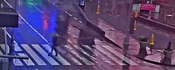

In [224]:
def createActionOfDict(adict):
    return eval(adict['class'])(**adict['parameters'])

_action = createActionOfDict(_action_dict)
_action.evaluate(imgs[1])

#imgs[1].size

#_action.__dict__
#_action_dict

In [196]:
_entry = videos['_hEh5wF6lxE']
video = pafy.new(_entry['url'])

In [225]:
import ipywidgets as widgets
style = {'description_width': '250px'}
layout = {'width': '500px'}

def on_next_button_clicked(b):  
    newvalue = int(frame.value) + 1
    if newvalue == len(imgs):
        newvalue = 0
    frame.value =  str(newvalue)
    #imageWidget.setImage(CropAction(**para_dict).evaluate(image=imgs[newvalue]))
    imageWidget.setImage(_action.evaluate(image=imgs[newvalue]))

def on_download_button_clicked(b):  
    global imgs
    next_button.disabled = True
    imgs = readImagesOfStream(video.streams[int(stream.value)],int(numberframes.value),skipframes=int(skipframes.value))
    frame.value = '0'
    next_button.disabled = False

def on_value_change_loop(b):
    if b['new'] == True:
        exe = HaltableExecutor(loop,sleep)
        exe.start()
        pending = asyncio.all_tasks()
        print(pending)
    else:
        for task in asyncio.all_tasks(): 
            if task.get_name() == 'test': 
                task.cancel()

    
stream     = widgets.Text(description   = 'stream',value = '1', style=style, layout=layout)
numberframes = widgets.Text(description = 'number frames',value = '10', style=style, layout=layout)
skipframes = widgets.Text(description   = 'skip frames',value = '10', style=style, layout=layout)
frame = widgets.Text(description = 'frame',value = '0', style=style, layout=layout)
sleep = widgets.Text(description = 'sleep',value = '0.0', style=style, layout=layout)
loop = widgets.Checkbox(description='loop',value=False)
#loop.observe(on_value_change_loop)    
download_button = widgets.Button(description='download', disabled=False, tooltip='resize',style=style, layout=layout)
download_button.on_click(on_download_button_clicked)  
next_button = widgets.Button(description='next', disabled=False, tooltip='resize',style=style, layout=layout)
next_button.on_click(on_next_button_clicked)  
vbox = widgets.VBox([stream,numberframes,skipframes,download_button,frame,sleep,loop,next_button])
display(vbox)
imageWidget=ImageWidget()
imageWidget.display()

Image(value=b'', format='PNG')

In [ ]:
imageWidget.getImage().rotate(0,0,-90)

In [226]:
import ipywidgets as widgets
import asyncio
import time

class HaltableExecutor:

    def __init__(self, checkbox,sleep):
        self._checkbox = checkbox
        self._sleep    = sleep
        
    async def my_code(self):
        # This is your user code
        while True:
            if self._checkbox.value:
                #print('running')  # put your code here
                on_next_button_clicked('b')
                time.sleep(float(self._sleep.value))
            await asyncio.sleep(0.1)  # use this to temporarily give up control of the event loop to allow scheduling checkbox changes
    
    def start(self):
        print('starting')
        #asyncio.current_task().foo = "Bar"
        #asyncio.current_task().name = "#{}".format(n)
        task = asyncio.ensure_future(self.my_code())
        task.set_name('test')
        #asyncio.current_task().name = 'test'
        
#c = widgets.Checkbox(description='click me',value=False)
#display(c)        

exe = HaltableExecutor(loop,sleep)
exe.start()

starting


In [ ]:
def deleteAllTasks(name):
    for task in asyncio.all_tasks(): 
                if task.get_name() == name: 
                    task.cancel()
                
pending = asyncio.all_tasks()
#next(iter(pending)).cancel()
len(pending)
#pending
#asyncio.current_task().set_name('test')
#next(iter(pending)).get_name()
#task, = [task for task in asyncio.all_tasks() if task.get_name() == 'test']
#task.get_name()
#deleteAllTasks('test')
pending

In [ ]:
imgs[18]

In [ ]:
resizeWidget.imageWidget.getImage()

In [ ]:
imageWidget.setImage(vstreams[0])

In [23]:
#### init

# tmp: to fix bug
videos = loadVideosFile()
video = pafy.new(videos.get(list(videos.keys())[0])['url'])
vstreams = getVstreams(video)
image = vstreams[0]


In [ ]:

#################

out = widgets.Output()

cropx0 = widgets.IntSlider(value=0, min=0,max=image.size[0],step=1, description='x0',layout=layout)
cropx1 = widgets.IntSlider(value=image.size[0], min=0,max=image.size[0],step=1, description='x1',layout=layout)
cropx0.observe(on_value_change_crop_xmin, 'value')
cropx1.observe(on_value_change_crop_xmax, 'value')

cropy0 = widgets.IntSlider(value=0, min=0,max=image.size[1],step=1, description='y0',layout=layout)
cropy1 = widgets.IntSlider(value=image.size[1], min=0,max=image.size[1],step=1, description='y1',layout=layout)
cropy0.observe(on_value_change_crop_ymin, 'value')
cropy1.observe(on_value_change_crop_ymax, 'value')

# new bookmark event
def on_value_submit_crop_name(change):
    #print(change)
    if change.value not in crop_list.options:
        crop_list.options = list(crop_list.options) + [change.value] 
    bookmark_dict[change.value] = toNormalizedMinMax(cropArea,image.size)
    crop_list.value = change.value
    
def crop_list_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        #print(bookmark_dict[change['new']])
        #initMinMax(image.size,bookmark_dict[change['new']])
        values = fromNormalizedMinMax(bookmark_dict[change['new']],image.size)
        initMinMax(image.size,values)
        crop_name.value = change['new']
        
def on_reset_button_clicked(b):
    cropArea      = [0,0,image.size[0],image.size[1]]
    initMinMax(image.size,cropArea)
    crop_name.value = ''
    #crop_list.value = ''
    
def updateImage():
    global image,cropArea
    #newimage = vstreams[index]
    newimage = getVstream(vstreams=vstreams, index=index)   
    newsize = newimage.size
    to = toNormalizedMinMax(cropArea,image.size)
    cropArea = fromNormalizedMinMax(to,newimage.size)
    imagea = newimage.crop(cropArea)
    image = newimage
    initMinMax(newsize,cropArea)
    crop_image() 
    
# select image slider
def on_value_change_imageselectw(change):
    #imageselectw.disabled=True
    global index
    index = change['new']
    updateImage()
    #imageselectw.disabled=False    
    
def on_next_image_button_clicked(b):
    global vstreams
    vstreams = getVstreams(video=video, indexes=[index])
    updateImage()
    
reset_button = widgets.Button(description='Reset', disabled=False, tooltip='reset all values',style=style)
reset_button.on_click(on_reset_button_clicked)  

next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
next_image_button.on_click(on_next_image_button_clicked)  

crop_name = widgets.Text(description = 'name',value = '', style=style, layout=layout,disabled=False)
crop_list = widgets.Dropdown(#options=video.streams,#value=video.streams[0], 
    description='bookmarks')
crop_bookmarks = widgets.HBox([crop_list,crop_name,reset_button])
crop_name.on_submit(on_value_submit_crop_name)
crop_list.observe(crop_list_on_change) 

imageselectw = widgets.IntSlider(value=0, min=0,max=len(vstreams)-1,step=1, description='image',layout=layout)
imageselectw.observe(on_value_change_imageselectw, 'value')

crop_hbox_x = widgets.HBox([cropx0, cropx1])
crop_hbox_y = widgets.HBox([cropy0, cropy1])
crop_vbox   = widgets.VBox([imageselectw,crop_bookmarks,crop_hbox_x, crop_hbox_y, next_image_button, out])


In [ ]:
####################### scale
options={'NEAREST' : Image.NEAREST,'BOX' : Image.BOX,'BILINEAR' : Image.BILINEAR,'HAMMING' : Image.HAMMING,'BICUBIC' : Image.BICUBIC,'LANCZOS' : Image.LANCZOS}
#options={Image.NEAREST,Image.BOX,Image.BILINEAR,Image.HAMMING,Image.BICUBIC,Image.LANCZOS}
#size_options = {(128,128),(224,224),(240,240),(256,256),(299,299),(300,300),(320,320),(513,513)}
size_options = {'(128,128)' : (128,128), '(224,224)' : (224,224), '(240,240)' : (240,240), '(256,256)' : (256,256),
                '(299,299)' : (299,299),'(300,300)' : (300,300),'(320,320)' : (320,320),'(513,513)' : (513,513),
                '(640,480)' : (640,480)}


def algorithmw_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print (change['new'])

def sizew_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        widthw.value  =  str(change['new'][0])        
        heightw.value =  str(change['new'][1])  
       
# the result: resized_image    
def on_update_button_clicked(b):        
    #print('update')
    global resized_image
    new_size = (int(widthw.value),int(heightw.value))
    resized_image = resize(image=cropped_image,new_size=new_size,algorithm=algorithmw.value)
    image_w.value = getByteArray(resized_image)
    
algorithmw = widgets.Dropdown(options=options,  description='algorithm', value = 0,style=style, layout=layout)
#algorithmw.observe(algorithmw_on_change,'value') 
sizew = widgets.Dropdown(options=size_options,  description='sizes', style=style, layout=layout)
sizew.observe(sizew_on_change,'value') 

widthw  = widgets.Text(description = 'width',value = '640', style=style, layout=layout,disabled=False)
heightw = widgets.Text(description = 'height',value = '480', style=style, layout=layout,disabled=False)
update_button = widgets.Button(description='Resize', disabled=False, tooltip='resize',style=style, layout=layout)
update_button.on_click(on_update_button_clicked)  
resize_vbox   = widgets.VBox([algorithmw,sizew,widthw,heightw,update_button])


In [20]:

############### add videos
import pafy
import cv2
import time
import json

vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

def saveVideosFile(filename='videos.json', videos=None):
    print(videos)
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(videos, f, ensure_ascii=False, indent=4)
        
def loadVideosFile(filename='videos.json'):
    with open('videos.json', 'r') as fp:
        videos = json.load(fp)  
        return videos



def readImageOfStream(stream):
    capture = cv2.VideoCapture(stream.url)
    grabbed, frame = capture.read()
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return image

def readImagesOfStream(stream, number, skipframes=0):
    global images
    images = []
    capture = cv2.VideoCapture(stream.url)

    for idx in range(0, number):
        grabbed, frame = capture.read()
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        images.append(image)
        
        for i in range(0, skipframes):
            grabbed, frame = capture.read()
            #print('skip',i)
    return images

def getVstreams(video=video, indexes=None):
    vstreams=[]
    for stream in video.streams:
        if indexes == None:
            image = readImageOfStream(stream)
            vstreams.append(image)
        else:
            vstreams.append(None) 
            
    if indexes != None:
        for index in indexes:
            image = readImageOfStream(video.streams[index])
            vstreams[index] = image
    return vstreams

def getVstream(vstreams=vstreams, index=None):
    if vstreams[index] == None:
        image = readImageOfStream(video.streams[index])
        vstreams[index] = image
    return vstreams[index]


def videoContainerTo_Dict():
    container = dict()
    container['url'] = video_url.value
    #container['streams'] = video_streams.options
    container['title'] = video_title.value
    container['location'] = video_location.value
    container['country'] = video_country.value
    container['objects'] = video_objects.value
    
    cropNormalizedArea = [0.0,0.0,1.0,1.0]    
    bookmark_dict = dict()
    bookmark_dict['reset'] = cropNormalizedArea
    container['bookmarks'] = bookmark_dict
    return container

def on_value_submit_video_url(change):
    print(change)
    global video
    video = pafy.new(change.value)
    video_title.value = video.title.rsplit('2021')[0].rstrip()
    video_streams.options = video.streams
    video_streams.value = video.streams[0]
    video_streams.disabled = False
    global vstreams
    vstreams = getVstreams(video)
      
def video_urls_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        url = videos[change['new']]['url']   
        global video
        video = video = pafy.new(url)
        global vstreams
        vstreams = getVstreams(video)
    
def on_video_load_button_clicked(b):        
    global videos
    filename = video_filename.value
    videos = loadVideosFile(filename=filename)
    video_urls.options = list(videos.keys())
    global video
    print(list(videos.keys())[0])
    print(videos.get(list(videos.keys())[0]))
    video = pafy.new(videos.get(list(videos.keys())[0])['url'])
    global vstreams
    vstreams = getVstreams(video)
    
def on_video_save_button_clicked(b):
    global videos
    filename = video_filename.value
    videos = loadVideosFile(filename=filename)
    container = videoContainerTo_Dict()
    key = container['url'].rsplit('/')[3]
    videos[key] = container
    video_urls.options = list(videos.keys())
    #print(videos)
    saveVideosFile(filename=filename,videos=videos)
    

NameError: name 'vstreams' is not defined

In [ ]:



video_filename = widgets.Text(description = 'filename',value = 'videos.json', style=vstyle, layout=vlayout,disabled=False)    
video_urls = widgets.Dropdown(description='videos', style=vstyle, layout=vlayout,disabled=False)
video_urls.observe(video_urls_on_change)

video_url = widgets.Text(description = 'url',value = '', style=vstyle, layout=vlayout,disabled=False)
video_url.on_submit(on_value_submit_video_url)
#video_streams = widgets.Text(description = 'streams',value = None, style=vstyle, layout=vlayout,disabled=True)
video_streams = widgets.Dropdown(description='streams', style=vstyle, layout=vlayout,disabled=True)
video_title = widgets.Text(description = 'title',value = '', style=vstyle, layout=vlayout,disabled=False)
video_location = widgets.Text(description = 'location',value = '', style=vstyle, layout=vlayout,disabled=False)
video_country = widgets.Text(description = 'country',value = '', style=vstyle, layout=vlayout,disabled=False)
video_objects = widgets.Text(description = 'objects',value = '', style=vstyle, layout=vlayout,disabled=False)

video_save_button = widgets.Button(description='Save', disabled=False, tooltip='reset all values',style=style)
video_save_button.on_click(on_video_save_button_clicked)  
video_load_button = widgets.Button(description='Load', disabled=False, tooltip='reset all values',style=style)
video_load_button.on_click(on_video_load_button_clicked)  

video_vbox   = widgets.VBox([video_filename,video_urls,video_url,video_streams,video_title,video_location,video_country,video_objects,video_load_button,video_save_button])

################ main tabs
tab  = widgets.Tab(children = [video_vbox, crop_vbox, resize_vbox])
tab.set_title(0, 'videos')
tab.set_title(1, 'crop')
tab.set_title(2, 'resize')

#print(image.size[0])
image_w = ipywidgets.Image(format='PNG')


display (tab)
display(image_w)

videos = dict()
index = 0
# init first image
image = vstreams[0]
cropArea      = [0,0,image.size[0],image.size[1]]
image_w.value = getByteArray(image)
initMinMax(image.size,cropArea)
cropped_image = image
resized_image = image
crop_list.options = bookmark_dict.keys()

In [ ]:

videos = loadVideosFile()
video = pafy.new(videos.get(list(videos.keys())[1])['url'])
vstreams = getVstreams(video)
image = vstreams[0]


In [ ]:
videos = loadVideosFile()
video = pafy.new(videos.get(list(videos.keys())[2])['url'])
imgs = readImagesOfStream(video.streams[2])


In [ ]:
imgs[19]

In [ ]:
imgs[12]

In [ ]:
def perform(fun, *args):
    fun(*args)

def action1(args=None):
    print(args)

def action2(args='', args2=''):
    print(args)

perform(action1)
perform(action2, args='p', args2='r')

In [ ]:
def A(p1 = 3, p2 = 4):
  print(str(p1) + str(p2))

para_dict = {"p1":1,"p2":0}
para_dict = {'p2':0}
A(**para_dict)

In [ ]:
class Cat:
    def say_hello(self, name):
        return 'Hello ' + name
    def init(self):
        pass
    
class Ball(Cat):
    # __init__ is a special method called whenever you try to make
    # an instance of a class. As you heard, it initializes the object.
    # Here, we'll initialize some of the data.
    def __init__(self):
        # Let's add some data to the [instance of the] class.
        self.position = (100, 100)
        self.velocity = (0, 0)

    # We can also add our own functions. When our ball bounces,
    # its vertical velocity will be negated. (no gravity here!)
    def bounce(self):
        self.velocity = (self.velocity[0], -self.velocity[1])
    def init(self):
        print('init')
    
    
ball = Ball()    

ball.bounce()
ball.position

def perform(fun,fun2, *args):
    fun.init()
    fun2(*args)
    print(fun.position,fun.say_hello('ball'))
    
perform(ball,ball.bounce)    


In [ ]:
cropped_image
#del bookmark_dict['change.value']
bookmark_dict.keys()
bookmark_dict

In [ ]:
#nitMinMax(image.size,fromNormalizedMinMax(bookmark_dict['test1'],image.size))
#fromNormalizedMinMax(bookmark_dict['test2'],image.size)
#on_reset_button_clicked('')
values = fromNormalizedMinMax(bookmark_dict['test2'],image.size)
initMinMax(image.size,values)

In [ ]:
if 'tree2' not in crop_list.options:
    print('not')
    
    
crop_list.options    

In [ ]:
print(image.size, cropArea)
initMinMax(image.size,cropArea)
size = image.size
cropx0.max = size[0]
cropx1.max = size[0]
cropy0.max = size[1]
cropy1.max = size[1]

cropx0.value = cropArea[0]
cropy0.value = cropArea[1]
cropx1.value = cropArea[2]
cropy1.value = cropArea[3]
cropx1.value,cropArea[2]

In [ ]:
cropped_image.size

# resize

In [ ]:
def resize(image=None,new_size=None,use_w=False,use_h=False,algorithm=Image.NEAREST):
    w = new_size[0]
    h = new_size[1]
    imagea = image
    
    ratio = h / imagea.size[1]
    newsize = (int(ratio * imagea.size[0]), int(ratio * imagea.size[1]) )

    ratio = w / imagea.size[0]
    h2 = int(ratio * imagea.size[1])
    w2 = int(ratio * imagea.size[0])
    if h2 > h:
        ratio = h / imagea.size[1]
        h2 = int(ratio * imagea.size[1])
        w2 = int(ratio * imagea.size[0])
    newsize = (w2, h2 )
    
    imageb = imagea.resize(newsize,algorithm)
    
    v = (int((new_size[0]-imageb.size[0])/2), int((new_size[1]-imageb.size[1])/2))
    new_im = Image.new("RGB", new_size) 
    new_im.paste(imageb, v)
    return new_im

In [ ]:
#https://stackoverflow.com/questions/44070427/whats-the-difference-between-various-image-resizing-algorithms-in-the-module-of

#imagea.resize((640,480),Image.ANTIALIAS)
#imagea.resize((640,480),Image.NEAREST)

imagea = cropped_image

w= 640 
h= 480
#h= 490

ratio = h / imagea.size[1]
newsize = (int(ratio * imagea.size[0]), int(ratio * imagea.size[1]) )

ratio = w / imagea.size[0]
h2 = int(ratio * imagea.size[1])
w2 = int(ratio * imagea.size[0])
if h2 > h:
    ratio = h / imagea.size[1]
    h2 = int(ratio * imagea.size[1])
    w2 = int(ratio * imagea.size[0])
newsize = (w2, h2 )

print(imagea.size,newsize)

imageb = imagea.resize(newsize,Image.LANCZOS)
#imageb = imagea.resize((640,480),Image.LANCZOS)
#imagea.thumbnail((80, 80), Image.ANTIALIAS)

new_size = (w, h)

v = (int((new_size[0]-imageb.size[0])/2), int((new_size[1]-imageb.size[1])/2))
print('v',v)

new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
new_im.paste(imageb, v)

print(imageb.size,new_im.size)
#imageb
new_im

In [ ]:
imageb

In [ ]:
import ipywidgets as widgets

out = widgets.Output()
def on_value_change(change):
    with out:
        print(change['new'])

slider = widgets.IntSlider(min=1, max=100, step=1, continuous_update=True)
play = widgets.Play(min=1, interval=2000)

slider.observe(on_value_change, 'value')
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.VBox([play, slider, out])

In [ ]:
def f(a, b):
    imagea = image.crop((200, 200, 600 + a, 600 + b))
    image_w.value = getByteArray(imagea)
    print(a,b)
    return
w = widgets.interactive(f, a=100, b=100)
display(w)

In [ ]:
image_w.value = getByteArray(image)

In [ ]:
#img = ImageTool(image=image)
#image.crop((200, 200, 600, 600))
image

In [ ]:
img.crop(0,0,100,100)
img.image

In [ ]:
import io
img_byte_arr = io.BytesIO()
img.image.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()
image_w.value = img_byte_arr

In [ ]:
fpsw    = addVisText(key='fps')
renderw = addVisCheckbox(key='',value=True)
box = widgets.Checkbox(False, description='checker')
display(box)

def changed(b):
    fpsw.value = str(box.value)
    #print(b)

renderw.observe(changed)
box.observe(changed)

In [ ]:
import threading
from IPython.display import display
import ipywidgets as widgets
def f(a, b):
    return

w = widgets.interactive(f, a=10, b=20)

def work(w):
    for ii in range(10):
        time.sleep(1)
        print(w.kwargs, w.result)

thread = threading.Thread(target=work, args=(w,))
display(w)
#thread.start()

In [ ]:
import enum
import cv2
#from .jpeg_encoder import JpegEncoder
import JpegEncoder

_ENCODER = JpegEncoder(width=224, height=224, fps=21)


def bgr8_to_jpeg_gst(value):
    return _ENCODER.encode(value)


def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])
image_w.value = bgr8_to_jpeg(image[:, ::-1, :])

In [ ]:
type(frame)
sizey=480
image = Image.fromarray(frame)
img = ImageTool(image=image,h=sizey)
#display(img.image)
clear_output(wait=True)
print('2')
#display(img.image)